In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import numpy as np
from functools import partial
import pandas as pd
from collections import namedtuple


import logging
import logzero
from logzero import logger

logzero.loglevel(logging.DEBUG)

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
import os
import sys
PACKAGE_PARENT = '.'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

## Simulation

### Simplifications

1. All the data is cleaned before simulation. (Forward-fill?)
2. All the data of same type is in the same format - **kWh** for energy.
3. Appliance has a positive flow, if it gets the energy and negative if energy comes from it.
4. Resulting in `data_production` data having negative flow at all times, `data_consumption` and `flow_loss` data always positive.
5. For start no system losses are taken into account, only the losses, where energy can not be exported to any appliance (not grid, not battery, not anything).
6. Data input for simulation is called `data`, what is computed is called either `state` - a description of current state of an appliance or `flow` - denoting the change of the state.
7. Balance is computed as `data_balance = - (data_production + data_consumption)`

Basic `data_array` consist of the following columns:

0. data_minute_of_day
1. data_consumption
2. data_production
3. data_balance
4. data_buy_price
5. data_sell_price


The following data is computed:

0. state_battery
1. flow_battery
2. flow_grid
3. flow_loss

In [5]:
sys.path

['',
 '/home/jernej/miniconda3/envs/doktorat/lib/python36.zip',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6/lib-dynload',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6/site-packages',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6/site-packages/pysftp-0.2.9-py3.6.egg',
 '/home/jernej/miniconda3/envs/doktorat/lib/python3.6/site-packages/IPython/extensions',
 '/home/jernej/.ipython',
 '/media/jernej/data01/Documents/python_projects/doktorat']

In [60]:
%%writefile ../SmartHousePy.py
from collections import namedtuple

import numpy as np
import pandas as pd

import logging
import logzero
from logzero import logger

logzero.loglevel(logging.DEBUG)

Battery_conf = namedtuple('Battery_conf',
                          '''max_charge
                          max_discharge
                          min_soc
                          max_soc
                          initial_soc
                          self_discharge_rate
                          charge_efficiency
                          discharge_efficiency''')

Grid_conf = namedtuple('Grid_conf',
                       '''max_to_grid
                       to_grid_efficiency''')


def if_then_else(condition, out_true, out_false):
    out_true() if condition() else out_false()
    
    
class SmartHouse(object):
    def __init__(self, data_array, battery_conf, grid_conf):
        # initial state is inserted as 0-th step/iteration
        data = np.vstack((np.zeros((1, data_array.shape[1])), data_array))
        self.data = data
        self.battery_conf = battery_conf
        self.grid_conf = grid_conf
        
        
        # 4 comes from:
        #    - state_battery 0
        #    - flow_battery  1
        #    - flow_grid     2
        #    - flow_loss     3        
        self.flow_state = np.zeros((data.shape[0], 4))
        self.flow_state[0, :] = [battery_conf.initial_soc, 0., 0., 0.]
        
        self.data_cols = ['data_minute_of_day',
                          'data_consumption',
                          'data_production',
                          'data_balance',
                          'data_buy_price',
                          'data_sell_price']
        
        assert len(self.data_cols) == data.shape[1], '{} != {}'.format(len(self.data_cols),
                                                                       data.shape[1])
        
        self.flow_state_cols = ['state_battery',
                                'flow_battery',
                                'flow_grid',
                                'flow_loss']
        
        assert len(self.flow_state_cols) == self.flow_state.shape[1], '{} != {}'.format(len(self.data_cols),
                                                                                        self.flow_state.shape[1])
        
        self.all_cols = self.data_cols + self.flow_state_cols
        self.all_data_df = pd.DataFrame(np.hstack((self.data, self.flow_state)), columns=self.all_cols)
        
        # needed for internal state
        self.iteration = 1
        self.checkpoint = 1
    
    def save_checkpoint(self):
        # stores the current iteration number as a checkpoint
        self.checkpoint = self.iteration
        logger.debug('Checkpoint saved: {}'.format(self.checkpoint))
        
        
    def rewind(self, checkpoint=None):
        # rewind back to previous stored checkpoint or
        # specified checkpoint
        if checkpoint is None:
            self.iteration = self.checkpoint
        else:
            if checkpoint < 1:
                logger.warn('Cannot rewind to iteration smaller than 1, setting it to 1.')
                self.iteration = 1
            else:
                self.iteration = checkpoint
        
        logger.debug('Rewinded to: {}'.format(self.iteration))
        
        
    def get_state(self, iteration=None):
        if iteration is None:
            iteration = self.iteration
        elif iteration == -1:
            logger.debug('Getting the state for previous iteration.')
            iteration = self.iteration - 1
        
        #state = np.hstack((self.data[iteration, :],
        #                  self.flow_state[iteration, :]))
        state = self.all_data_df.loc[iteration].values
        
        value_pairs = ', '.join(['{}:{}'.format(name, value) for name,value in zip(self.all_cols, state)])
        logger.debug('State in iteration {} is [{}]'.format(iteration, value_pairs))
        return state
    
    
    def get_subdata(self, cols=None, start=None, end=None):
        if cols is None:
            return self.all_data_df.loc[start:end]
        else:
            return self.all_data_df.loc[start:end, cols]
    
    ########################################################
    #                    Evaluations
    ########################################################
    
    def green(self, start=None, end=None):
        ###total_pv = -np.sum(self.data_pv)  # add - because, data flow is negative from pv
        ###total_loss = np.sum(self.flow_loss)
        ###total_to_grid = np.sum(self.flow_grid[self.flow_grid >= 0])
        ###total_load = np.sum(self.data_load)
        
        #subset_data = self.data[start:end,:]
        #subset_flow_state = self.flow_state[start:end,:]
        subdata = self.get_subdata(start, end)
        
        #total_pv = -np.sum(subset_data[:, 2])
        #total_loss = np.sum(subset_flow_state[:, 3])
        #total_to_grid = np.sum(subset_flow_state[subset_flow_state[:, 2] > 0, 2])
        #total_load = np.sum(subset_data[:, 1])
        
        total_pv = -np.sum(subdata['data_production'])
        total_loss = np.sum(subdata['flow_loss'])
        total_to_grid = np.sum(subdata.loc[subdata['flow_grid'] > 0, 'flow_grid'])
        total_load = np.sum(subdata['data_consumption'])
        
        logger.debug('Total production is {}'.format(total_pv))
        logger.debug('Total loss is {}'.format(total_loss))
        logger.debug('Total to grid is {}'.format(total_to_grid))
        logger.debug('Total load is {}'.format(total_load))
        if total_load == 0:
            green =  np.inf
        else:
            green = (total_pv - total_loss - total_to_grid) / total_load
        logger.debug('Green factor is {}'.format(green))
        return green
    
    
    def cost(self, start=None, end=None):
        
        ###to_grid = self.flow_grid >= 0
        ###profit = np.sum(self.data_sell_prices[to_grid] * self.flow_grid[to_grid])
        ###### add - to costs, because data flow from grid is negative
        ###cost = -np.sum(self.data_buy_prices[~to_grid] * self.flow_grid[~to_grid]) 
        
        #subset_data = self.data[start:end,:]
        #subset_flow_state = self.flow_state[start:end,:]
        subdata = self.get_subdata(start, end)
        
        #to_grid = subset_flow_state[:, 2] > 0
        #profit = np.sum(subset_data[to_grid, 5] * subset_flow_state[to_grid, 2])
        to_grid = subdata['flow_grid'] > 0
        profit = np.sum(subdata.loc[to_grid, 'flow_grid'] * subdata.loc[to_grid, 'data_sell_price'])
        
        ### add - to costs, because data flow from grid is negative
        #cost = -np.sum(subset_data[~to_grid, 4] * subset_flow_state[~to_grid, 2]) 
        cost = -np.sum(subdata.loc[~to_grid, 'flow_grid'] * subdata.loc[~to_grid, 'data_buy_price']) 
        total_cost = cost - profit 
             
        logger.debug('Pure cost is {}'.format(cost))
        logger.debug('Pure profit is {}'.format(profit))
        logger.debug('Total cost is {}'.format(total_cost))
        return total_cost
    
    
    def fitness(self, start=None, end=None):
        cost = self.costs(start, end)
        green_inv = 100 * (1. - self.green(start, end))
        return cost, green_inv
    
    
    def max_peak(self, start=None, end=None):
        ###return self.flow_grid.max()
        #max_peaked = -np.min(self.flow_state[start:end,2])
        max_peaked = -np.min(self.get_subdata('flow_grid', start, end))
        max_peaked = max(0, max_peaked)
        logger.debug('Max peak is {}'.format(max_peaked))
        return max_peaked
    
    
    ########################################################
    #                    Run routines
    ########################################################
    
    def make_step(self, routine):
        routine()
        self.iteration += 1
        logger.debug('Made step with routine {}'.format(routine))
        
    def run(self, routine, n_steps):
        for _ in range(n_steps):
            routine()
    
    ########################################################
    #               ROUTINES
    ########################################################
    def set_computed(self, new_flow_battery, new_flow_grid, iteration):
        if iteration is None:
            iteration = self.iteration
            
        #new_balance = self.data[iteration, 3]
        #previous_state_battery = self.flow_state[iteration - 1, 0]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        previous_state_battery = self.all_data_df.loc[iteration-1, 'state_battery']
        
        new_state_battery = previous_state_battery + new_flow_battery
        
        new_flow_loss = new_balance - new_flow_battery - new_flow_grid
        
        new_state = [new_state_battery,
                     new_flow_battery,
                     new_flow_grid,
                     new_flow_loss]
        
        #self.flow_state[iteration, :] = new_state
        self.all_data_df.loc[iteration, self.flow_state_cols] = new_state
                           
        logger.debug('SmartHouse.flow_state [state_battery, flow_battery, flow_grid, flow_loss] {}'.format(new_state))      
                           
    
    # ------------ BASIC ACTIONS ------------------------------------#
    
    def first_to_battery(self, iteration=None):
        """
        Direct the flow to battery first then to grid.
        """
        if iteration is None:
            iteration = self.iteration
                           
        logger.debug('first_to_battery in iteration {}'.format(iteration))
        
        #new_balance = self.data[iteration, 3]
        #previous_state_battery = self.flow_state[iteration - 1, 0]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        previous_state_battery = self.all_data_df.loc[iteration-1, 'state_battery']
        
        
        new_flow_battery = min(self.battery_conf.max_charge,
                               self.battery_conf.max_soc - previous_state_battery,
                               new_balance)
        
        new_flow_grid = min(self.grid_conf.max_to_grid,
                            new_balance - new_flow_battery)
        
        self.set_computed(new_flow_battery, new_flow_grid, iteration)
                           
    def first_to_grid(self, iteration=None):
        """
        Direct the flow to grid first, then to battery if the grid
        can't take it all.
        """
        if iteration is None:
            iteration = self.iteration
                           
        logger.debug('first_to_grid in iteration {}'.format(iteration))
                          
        #new_balance = self.data[iteration, 3]
        #previous_state_battery = self.flow_state[iteration - 1, 0]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        previous_state_battery = self.all_data_df.loc[iteration-1, 'state_battery']
                           
        new_flow_grid = min(self.grid_conf.max_to_grid,
                            new_balance)
        
        new_flow_battery = min(self.battery_conf.max_charge,
                               self.battery_conf.max_soc - previous_state_battery,
                               new_balance - new_flow_grid)
        
        self.set_computed(new_flow_battery, new_flow_grid, iteration)
        

    
    def first_from_battery(self, iteration=None):
        """
        Direct the flow FROM battery first, then from grid if necessary.
        Balance should be negative
        """
        if iteration is None:
            iteration = self.iteration
                           
        logger.debug('first_from_battery in iteration {}'.format(iteration))
        
        #new_balance = self.data[iteration, 3]
        #previous_state_battery = self.flow_state[iteration - 1, 0]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        previous_state_battery = self.all_data_df.loc[iteration-1, 'state_battery']
                           
        
        new_flow_battery = - min(self.battery_conf.max_discharge,
                                 previous_state_battery - self.battery_conf.min_soc,
                                 -new_balance)                          
                           
        new_flow_grid = new_balance - new_flow_battery
        
        self.set_computed(new_flow_battery, new_flow_grid, iteration)
        
    
    def first_from_grid(self, iteration=None):
        """
        Direct the flow from grid first. There are no limits.
        """
        if iteration is None:
            iteration = self.iteration
                           
        logger.debug('first_from_grid in iteration {}'.format(iteration))
        
        # since the grid can provide unlimited energy, none is needed from battery
        new_flow_battery = 0.
        
        # the balance is negative in this case, so should be the grid flow
        #new_balance = self.data[iteration, 3]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        new_flow_grid = new_balance
        
        self.set_computed(new_flow_battery, new_flow_grid, iteration)

    
    # ------------ COMPOSED ACTIONS --------------------------------#
    
    def default_routine(self, iteration=None):
        """
        This is a default controller that uses the battery first (in and out)
        and the grid as a backup.
        """ 
        if iteration is None:
            iteration = self.iteration
                           
        #new_balance = self.data[iteration, 3]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        if new_balance >= 0:
            self.first_to_battery()
        else:
            self.first_from_battery()
    
    def use_battery_first(self, iteration=None):
        """
        This routine uses battery first (in and out) and a grid as a backup.
        
        This routine is actually the same as the default routine. Different 
        name is used for easier interpretation of the GP results.
        """
        if iteration is None:
            iteration = self.iteration
                           
        #new_balance = self.data[iteration, 3]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        if new_balance >= 0:
            self.first_to_battery()
        else:
            self.first_from_battery()
        
    def use_grid_first(self, iteration=None):
        """
        This routine uses grid first (in and out) and a battery as a backup.
        """
        if iteration is None:
            iteration = self.iteration
                           
        #new_balance = self.data[iteration, 3]
        new_balance = self.all_data_df.loc[iteration, 'data_balance']
        if new_balance >= 0:
            self.first_to_grid()
        else:
            self.first_from_grid()
    
    #def use_oportunist_sell(self):
    #    now_balance = self.data[iteration, 3]
    #    if now_balance >= 0:
    #        if self.data_sell_prices[self.now] > self.pday_avg_data_sell_prices[self.now]:
    #            self.first_to_grid()
    #        else:
    #            self.first_to_battery()
    #    else:
    #        self.first_from_battery()
    
    def get_actions(self):
        actions = [
            self.use_battery_first,
            self.use_grid_first
        ]
        return actions

    
    def ith_leq_then_else(self, feature_id, feature_value, out_true, out_false):
        def partial():
            out_true() if self.get_state()[feature_id] <= feature_value else out_false()
        return partial

Overwriting ../SmartHousePy.py


In [55]:
%aimport SmartHousePy 
from SmartHousePy import SmartHouse, Battery_conf, Grid_conf

In [40]:
test_battery = Battery_conf(1, 1, 1, 5, 2, 0.1, 1., 1.)
test_grid = Grid_conf(1, 1.)
test_data = np.array([[30, 1, 1, 0, 0.1, 0.01]])

In [41]:
sh1 = SmartHouse(test_data, test_battery, test_grid)

In [47]:
sh1.make_step(sh1.first_to_battery)

[D 170823 13:24:23 SmartHousePy:222] first_to_battery in iteration 2


IndexError: index 2 is out of bounds for axis 0 with size 2

In [48]:
sh1.get_state(0)

[D 170823 13:24:25 SmartHousePy:105] State in iteration 0 is [data_minute_of_day:0.0, data_consumption:0.0, data_production:0.0, data_balance:0.0, data_buy_price:0.0, data_sell_price:0.0, state_battery:2.0, flow_battery:0.0, flow_grid:0.0, flow_loss:0.0]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.])

In [49]:
sh1.rewind(0)

[W 170823 13:24:26 SmartHousePy:86] Cannot rewind to iteration smaller than 1, setting it to 1.
[D 170823 13:24:26 SmartHousePy:91] Rewinded to: 1


In [ ]:
class HouseData(object):
    def __init__(self, consumption_data_path, production_data_path, prices_data_path):
        consumption_data = pd.read_csv(consumption_data, index_col=1)
        consumption_data = pd.read_csv(consumption_data)
        consumption_data = pd.read_csv(consumption_data)

In [23]:
consumption_data_path_ = '../data/processed/consumption/ld2011_2014.csv'

In [29]:
consumption_data_ = pd.read_csv(consumption_data_path_, index_col=0, parse_dates=[0])

In [30]:
consumption_data_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70129 entries, 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 198.5 MB


In [65]:
consumption_data_.head(3)

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
Time                                                                          
2011-01-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-01 00:30:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2011-01-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                     MT_008  MT_009  MT_010   ...    MT_361  MT_362  MT_363  \
Time                                          ...                             
2011-01-01 00:00:00     NaN     NaN     NaN   ...       NaN     NaN     NaN   
2011-01-01 00:30:00     NaN     NaN     NaN   ...       NaN     NaN     NaN   
2011-01-01 01:00:00     NaN     NaN     NaN   ...       NaN     NaN     NaN   

                     MT_364  MT_365  MT_366  MT_367  MT_368  MT_369  MT_370  
Time                                                                         
2011-01-01 00:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2011-01-01 00:30:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2011-01-01 01:00:00     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[3 rows x 370 columns]

In [32]:
production_data_path_ = '../data/processed/weather/1824.csv'

In [34]:
production_data_ = pd.read_csv(production_data_path_, index_col=0, parse_dates=[0])
production_data_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173904 entries, 2007-01-01 00:00:00 to 2016-12-01 23:30:00
Data columns (total 16 columns):
difuzno sev.       172011 non-null float64
globalno sev.      170700 non-null float64
hitrost vetra      172047 non-null float64
max. T             170802 non-null float64
max. rel. vla.     170789 non-null float64
max. tlak          170380 non-null float64
min. T             170802 non-null float64
min. rel. vla.     170789 non-null float64
min. tlak          170380 non-null float64
p14                171984 non-null float64
povp. T            170829 non-null float64
povp. rel. vla.    170811 non-null float64
povp. tlak         170407 non-null float64
smer vetra         170699 non-null float64
sunki vetra        170699 non-null float64
production         170647 non-null float64
dtypes: float64(16)
memory usage: 22.6 MB


In [66]:
production_data_.head(3)

difuzno sev.  globalno sev.  hitrost vetra  max. T  \
index                                                                     
2007-01-01 00:00:00           0.0            0.8            0.0     5.9   
2007-01-01 00:30:00           0.0            0.8            0.0     5.9   
2007-01-01 01:00:00           0.0            0.9            0.0     5.9   

                     max. rel. vla.  max. tlak  min. T  min. rel. vla.  \
index                                                                    
2007-01-01 00:00:00           100.0     1029.0     5.8           100.0   
2007-01-01 00:30:00           100.0     1028.0     5.9           100.0   
2007-01-01 01:00:00           100.0     1028.0     5.8           100.0   

                     min. tlak  p14  povp. T  povp. rel. vla.  povp. tlak  \
index                                                                       
2007-01-01 00:00:00     1028.0  0.0      5.8            100.0      1028.0   
2007-01-01 00:30:00     1028.0  0.0      5.9            100.0      1028.0   
2007-01-01 01:00:00     1028.0  0.0      5.8            100.0      1028.0   

                     smer vetra  sunki vetra  production  
index                                                     
2007-01-01 00:00:00         0.1          2.0    0.000431  
2007-01-01 00:30:00         0.1        317.0    0.000431  
2007-01-01 01:00:00         0.2        170.0    0.000484

In [93]:
%matplotlib notebook

<IPython.core.display.Javascript object>


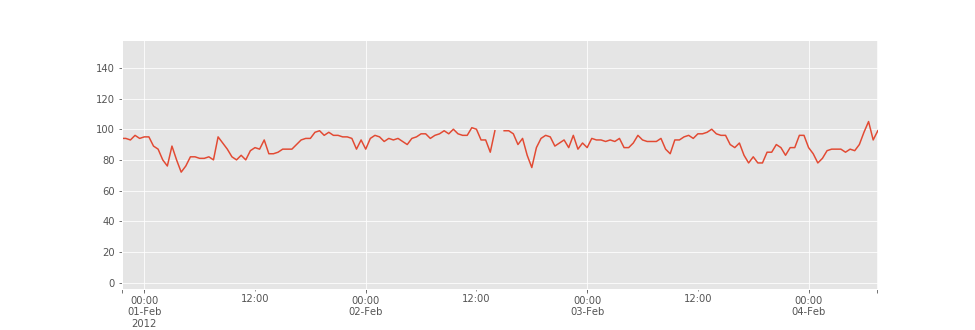

In [95]:
production_data_['sunki vetra'].plot()

In [61]:
prices_data_path_ = '../data/processed/prices/epexspotde.csv'

In [62]:
prices_data_ = pd.read_csv(prices_data_path_, index_col=0, parse_dates=[0])

In [63]:
prices_data_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80966 entries, 2011-12-14 13:00:00 to 2016-10-23 23:30:00
Data columns (total 8 columns):
low             80965 non-null float64
high            80965 non-null float64
last            80504 non-null float64
weighted_avg    80965 non-null float64
index.1         23852 non-null float64
id3_price       23180 non-null float64
vol_buy         80965 non-null float64
vol_sell        80965 non-null float64
dtypes: float64(8)
memory usage: 8.1 MB


In [67]:
prices_data_.head(3)

low   high   last  weighted_avg  index.1  id3_price  \
index                                                                        
2011-12-14 13:00:00  0.049  0.057  0.057      0.050615      NaN        NaN   
2011-12-14 13:30:00  0.049  0.065  0.065      0.057000      NaN        NaN   
2011-12-14 14:00:00  0.062  0.064  0.064      0.063000      NaN        NaN   

                     vol_buy  vol_sell  
index                                   
2011-12-14 13:00:00     66.0      66.0  
2011-12-14 13:30:00    160.0     160.0  
2011-12-14 14:00:00     80.0      80.0